In [15]:
from qiskit import *
from qiskit.circuit.library import MCXGate, ZGate
from math import pi

In [ ]:
def get_sat() -> tuple[int, list[list[int]]]:
    """
    To enter the clause type all the literals present in the clause separated by comma,
    if the literal is negated enter a `-` sign in front of it.
    ex: 1,3,-4 is the clause (X1 V X3 V ¬X4)
    """
    x = int(input("Enter the ammount of literals: "))
    cnf = []
    while True:
        clause = list(map(int, input("Enter a clause").split(",")))
        if clause[0] == 0:
            break
        else:
            cnf.append(clause)
    return (x, cnf)

print(get_sat())

In [2]:
def sat_clause_control_string(l: list[int]) -> str:
    c_string = ""
    for i in l:
        if i > 0:
            c_string += "0"
        else:
            c_string += "1"
    return c_string[::-1]

print(sat_clause_control_string([2, -4, -5]))

110


In [ ]:
def sat_UF(sat_x: int, sat_clauses: list[list[int]]) -> QuantumCircuit:
    x = QuantumRegister(sat_x, "x")
    anc = QuantumRegister(len(sat_clauses), "anc")
    r = QuantumRegister(1, "r")
    quantum_circuit = QuantumCircuit(x,anc,r,name="SAT-UF")
    quantum_circuit.x(anc)
    for i in range(len(sat_clauses)):
        c_string = sat_clause_control_string(sat_clauses[i])
        clause_i = MCXGate(len(sat_clauses[i]), ctrl_state=c_string)
        indexes = list(map(lambda a: abs(a)-1, sat_clauses[i]))
        quantum_circuit.append(clause_i, indexes + anc[i:i+1])
    quantum_circuit.append(MCXGate(len(sat_clauses)), anc[:] + r[:])
    return quantum_circuit

#circ = sat_UF(5, [[1, 2, 3], [2, -4, -5], [3, 4, 5]])
circ = sat_UF(3, [[1, 2, 3], [1, 2, -3]])
circ.draw("mpl")


'\n- - -\n- - +\n\n3 negs\n2 negs 1 pos\n\n'

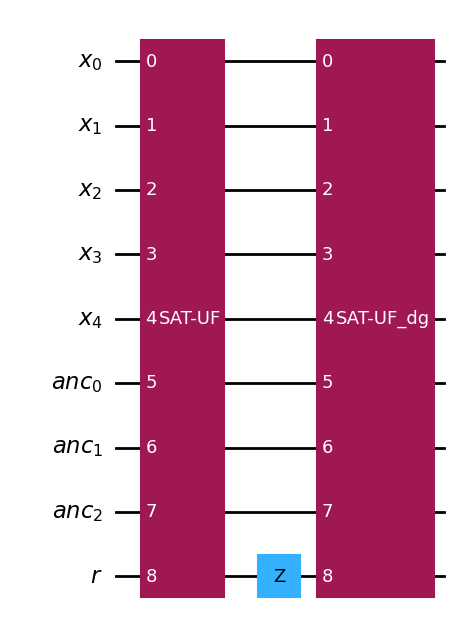

In [4]:
def sat_UG(bit_array: list[int], UF: QuantumCircuit) -> QuantumCircuit:
    x = QuantumRegister(bit_array[0], "x")
    anc = QuantumRegister(bit_array[1], "anc")
    r = QuantumRegister(bit_array[2], "r")
    quantum_circuit = QuantumCircuit(x,anc,r,name="SAT_UG")
    quantum_circuit.append(UF, x[:] + anc[:] + r[:])
    quantum_circuit.z(r[0])
    quantum_circuit.append(UF.inverse(), x[:] + anc[:] + r[:])
    return quantum_circuit

sat_UG([5,3,1], sat_UF(5,[[1, 2, 3], [2, -4, -5], [3, 4, 5]])).draw("mpl")

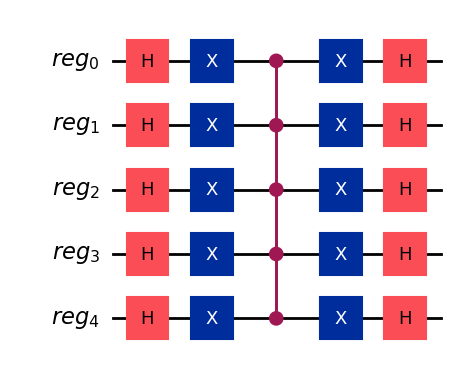

In [14]:
def inversion_by_the_mean(num_bits: int) -> QuantumCircuit:
    reg = QuantumRegister(num_bits, "reg")
    quantum_circuit = QuantumCircuit(reg, name="inversion-by-the-mean")
    quantum_circuit.h(reg)
    quantum_circuit.x(reg)
    quantum_circuit.append(ZGate().control(num_bits-1), reg[:])
    quantum_circuit.x(reg)
    quantum_circuit.h(reg)
    return quantum_circuit

inversion_by_the_mean(5).draw("mpl")

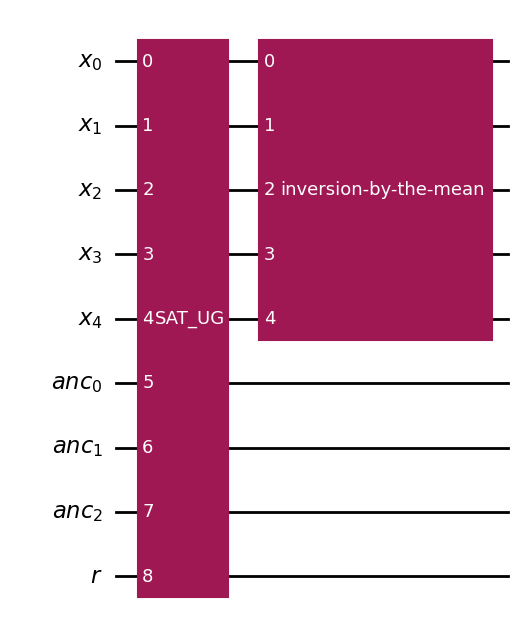

In [6]:
def grover(bit_array: list[int], sat_clauses: list[list[int]]) -> QuantumCircuit:
    """
    bit array is the array that contains the how many bits will be used in witch register
    [5,3,1] means 5 input bits, 3 anc bits and 1 result bit.
    """
    x = QuantumRegister(bit_array[0], "x")
    anc = QuantumRegister(bit_array[1], "anc")
    r = QuantumRegister(bit_array[2], "r")
    quantum_circuit = QuantumCircuit(x,anc,r,name="grover-SAT")
    UG = sat_UG(bit_array, sat_UF(bit_array[0],sat_clauses).to_gate()).to_gate()
    inv = inversion_by_the_mean(bit_array[0]).to_gate()
    quantum_circuit.append(UG, x[:] + anc[:] + r[:])
    quantum_circuit.append(inv, x[:])
    return quantum_circuit

grover([5,3,1], [[1, 2, 3], [2, -4, -5], [3, 4, 5]]).draw("mpl")

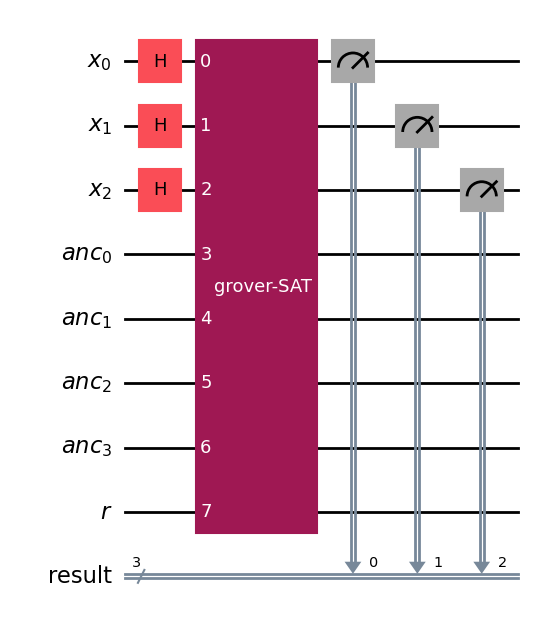

In [7]:
#fnc = [[1], [-2], [-3], [-1,-2], [-1,-3], [-2,-3]]
#fnc = [[1,2,3],[1,2,-3],[1,-2,3],[1,-2,-3],[-1,2,3],[-1,2,-3],[-1,-2,3],[-1,-2,-3]]
fnc = [[1],[2],[1,3],[1,-3]]
bits = [3,len(fnc),1]


G = grover(bits, fnc)
x = QuantumRegister(bits[0], "x")
anc = QuantumRegister(bits[1], "anc")
r = QuantumRegister(bits[2], "r")
result = ClassicalRegister(bits[0], "result")
qc = QuantumCircuit(x,anc,r,result)
qc.h(x)
#qc.h(r)
#m marked states
m = 2
num_reps = int((pi/4)*(((2**bits[0])/m)**(1/2)))
for i in range(num_reps):
  qc.append(G, x[:] + anc[:] + r[:])
qc.measure(x, result)
qc.draw("mpl")

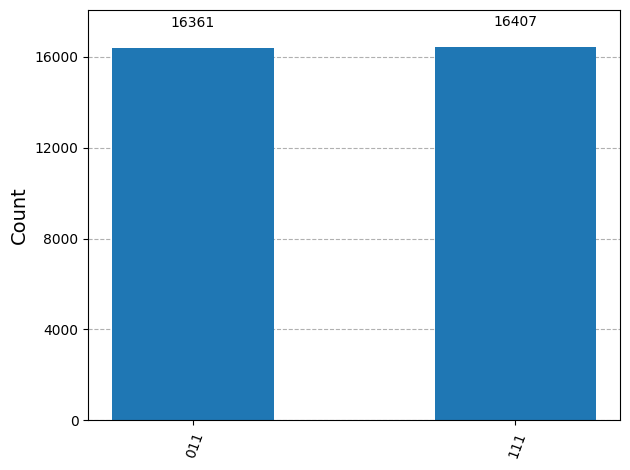

In [8]:
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.visualization import plot_histogram

simulator_aer = AerSimulator()

qc_aer = transpile(qc, backend=simulator_aer)

job = simulator_aer.run(qc_aer, shots=(1<<15))
job_result = job.result()
counts = job_result.get_counts(qc_aer)

plot_histogram(counts)

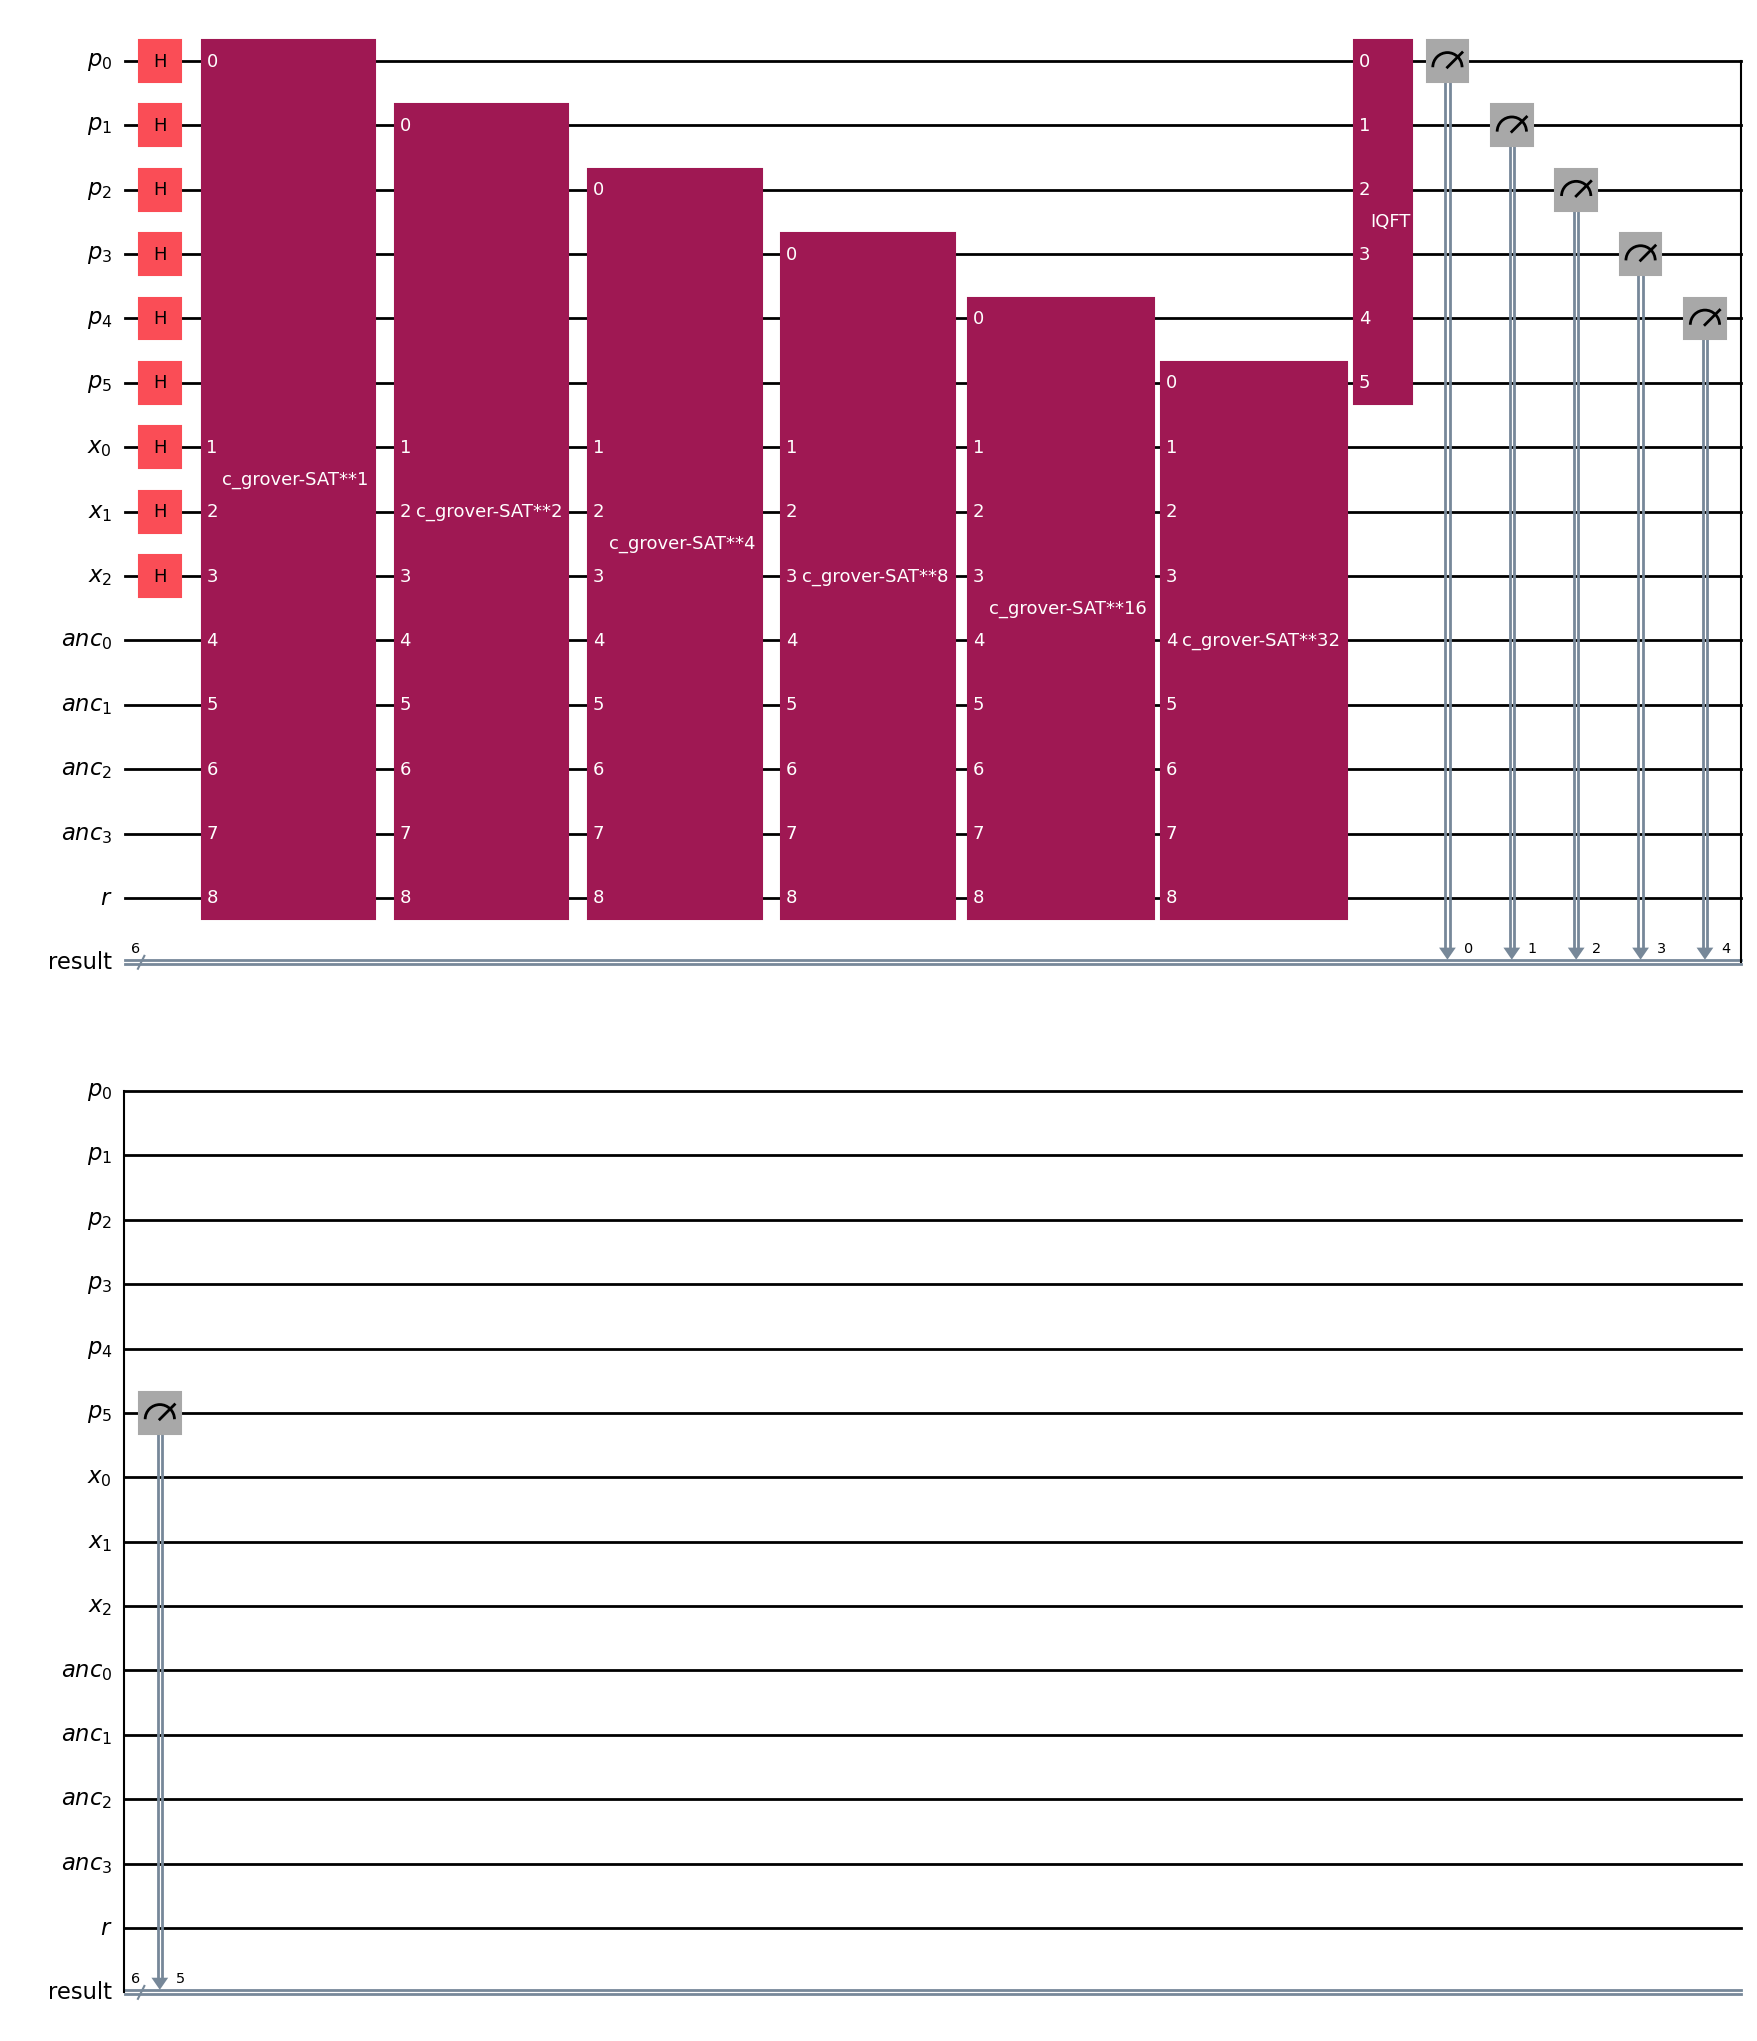

In [16]:
from qiskit.circuit.library import QFT
#fnc = [[1], [-2], [-3], [-1,-2], [-1,-3], [-2,-3]]
fnc = [[1],[2],[1,3],[1,-3]]
#fnc = [[1,2,3],[1,2,-3],[1,-2,3],[1,-2,-3],[-1,2,3],[-1,2,-3],[-1,-2,3],[-1,-2,-3]]
bits = [3,len(fnc),1,6]
G = grover(bits, fnc)
x = QuantumRegister(bits[0], "x")
anc = QuantumRegister(bits[1], "anc")
r = QuantumRegister(bits[2], "r")
p = QuantumRegister(bits[3], "p")
result = ClassicalRegister(bits[3], "result")
qc = QuantumCircuit(p,x,anc,r,result)
qc.h(p)
qc.h(x)
num_reps = bits[3]
for i in range(num_reps):
  qc.append(G.power(2**i).control(1), p[i:i+1] + x[:] + anc[:] + r[:])
qc.append(QFT(bits[3], inverse=True), p[:])
qc.measure(p, result)
qc.draw("mpl")

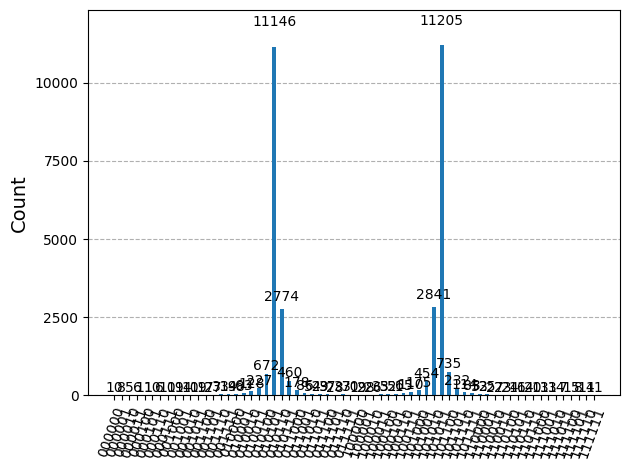

In [ ]:
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.visualization import plot_histogram

simulator_aer = AerSimulator()

qc_aer = transpile(qc, backend=simulator_aer)

job = simulator_aer.run(qc_aer, shots=(1<<15))
job_result = job.result()
counts = job_result.get_counts(qc_aer)

plot_histogram(counts)

In [11]:
print(int(counts.most_frequent(),2))

43


In [12]:
from math import pi, sin, sqrt, asin
# N = 2^num_literals
N = 2**3
#theta = 2pi * measured value / 2^num_precision_bits
#M = N*sin^2(theta/2)
#solutions = N-M
theta = 2*pi*int(counts.most_frequent(),2)/(2**4)
m = N*(sin(theta/2))**2
print(f"M = {m}")
print(f"N = {N}")
print(f"Number of solutions: ~{N-m}")

M = 5.530733729460364
N = 8
Number of solutions: ~2.469266270539636
